In [1]:
# General imports
import numpy as np
import re
import sympy as sp
import json

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2, TwoLocal, RealAmplitudes
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize, differential_evolution, basinhopping

# Plotting functions
import matplotlib.pyplot as plt

# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

aer_sim = AerSimulator(method='statevector')
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)

In [2]:
def create_matrix(cut_off, type):
    # Initialize a zero matrix of the specified size
    matrix = np.zeros((cut_off, cut_off), dtype=np.complex128)
    
    # Fill the off-diagonal values with square roots of integers
    for i in range(cut_off):
        if i > 0:  # Fill left off-diagonal
            if type == 'q':
                matrix[i][i - 1] = (1/np.sqrt(2)) * np.sqrt(i)  # sqrt(i) for left off-diagonal
            else:
                matrix[i][i - 1] = (1j/np.sqrt(2)) * np.sqrt(i)

        if i < cut_off - 1:  # Fill right off-diagonal
            if type == 'q':
                matrix[i][i + 1] = (1/np.sqrt(2)) * np.sqrt(i + 1)  # sqrt(i + 1) for right off-diagonal
            else:
                matrix[i][i + 1] = (-1j/np.sqrt(2)) * np.sqrt(i + 1)

    return matrix

In [75]:
# Function to calculate the Hamiltonian
def calculate_Hamiltonian(cut_off):
    # Generate the position (q) and momentum (p) matrices
    q = create_matrix(cut_off, 'q')  # q matrix
    p = create_matrix(cut_off, 'p')  # p matrix
    
    #fermionic identity
    I_f = np.eye(2)

    #bosonic identity
    I_b = np.eye(cut_off)

       
    # Superpotential derivatives
    W_prime = q  # W'(q) = q
    W_double_prime = np.eye(cut_off)

    # Kinetic term: p^2
    p2 = np.dot(p, p)

    # Commutator term [b^†, b] = -Z
    Z = np.array([[1, 0], [0, -1]])  # Pauli Z matrix for fermion number
    commutator_term = np.kron(Z, W_double_prime)

    # Construct the block-diagonal kinetic term (bosonic and fermionic parts)
    # Bosonic part is the same for both, hence we use kron with the identity matrix
    kinetic_term = np.kron(I_f, p2)

    # Potential term (W' contribution)
    potential_term = np.kron(I_f, np.dot(W_prime, W_prime))

    # Construct the full Hamiltonian
    H_SQM = 0.5 * (kinetic_term + potential_term + commutator_term)
    H_SQM[np.abs(H_SQM) < 10e-10] = 0
    
    return H_SQM

In [128]:
cut_off = 32
H = calculate_Hamiltonian(cut_off)

In [129]:
eigenvalues = np.sort(np.linalg.eig(H)[0])

In [130]:
hamiltonian = SparsePauliOp.from_operator(H)
ansatz = RealAmplitudes(num_qubits=hamiltonian.num_qubits, reps=1)
ansatz_isa = pm.run(ansatz)
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [131]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    #result = estimator.run(pubs=[pub], precision=0.001).result()
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)

    return energy

In [132]:
num_params = ansatz.num_parameters
x0 = 2 * np.pi * np.random.random(num_params)

In [133]:
energies = []
x_values = []

backend=aer_sim
estimator = Estimator(mode=backend)

for i in range(100):

    if i % 10 == 0:
        print(f"Run: {i}")

    res = minimize(
        cost_func,
        x0,
        method= "COBYLA",
        args= (ansatz_isa, hamiltonian_isa, estimator),
        options= {'maxiter':10000}
        #tol = 10e-10
    )
    energies.append(res.fun)
    x_values.append(res.x)

    #closest_e = min(enumerate(energies), key=lambda x: abs(x[1] - 0))[0]
    #closest_x = x_values[closest_e]
    #x0 = closest_x

Run: 0
Run: 10
Run: 20
Run: 30
Run: 40
Run: 50
Run: 60
Run: 70
Run: 80
Run: 90


In [134]:
run = {
    'potential': 'QHO',
    'cutoff': cut_off,
    'exact_eigenvalues': [round(x.real,10).tolist() for x in eigenvalues],
    'ansatz': 'RealAmplitudes',
    'num_VQE': 100,
    'backend': 'aer_simulator',
    'estimator_shots': 10000,
    'min_function': {'name': 'minimizer',
                     'method': "COBYLA",
                     'maxiter':10000
                    },
    'results': energies,
    'x_values': [x.tolist() for x in x_values]
}

In [135]:
path = r"C:\Users\Johnk\OneDrive\Desktop\PhD 2024\Quantum Computing Code\Quantum-Computing\Qiskit\SUSY VQE\Minimizer\Files\QHO\QHO_{}.json".format(cut_off)

In [136]:
# Save the variable to a JSON file
with open(path, 'w') as json_file:
    json.dump(run, json_file, indent=4)

In [137]:
n_values = [2, 4, 8, 16, 32]
data_dict = {}

base_path = r"C:\Users\Johnk\OneDrive\Desktop\PhD 2024\Quantum Computing Code\Quantum-Computing\Qiskit\SUSY VQE\Minimizer\Files\QHO\QHO_{}.json"

for n in n_values:
    file_path = base_path.format(n)
    with open(file_path, 'r') as json_file:
        data_dict[f'c{n}'] = json.load(json_file)

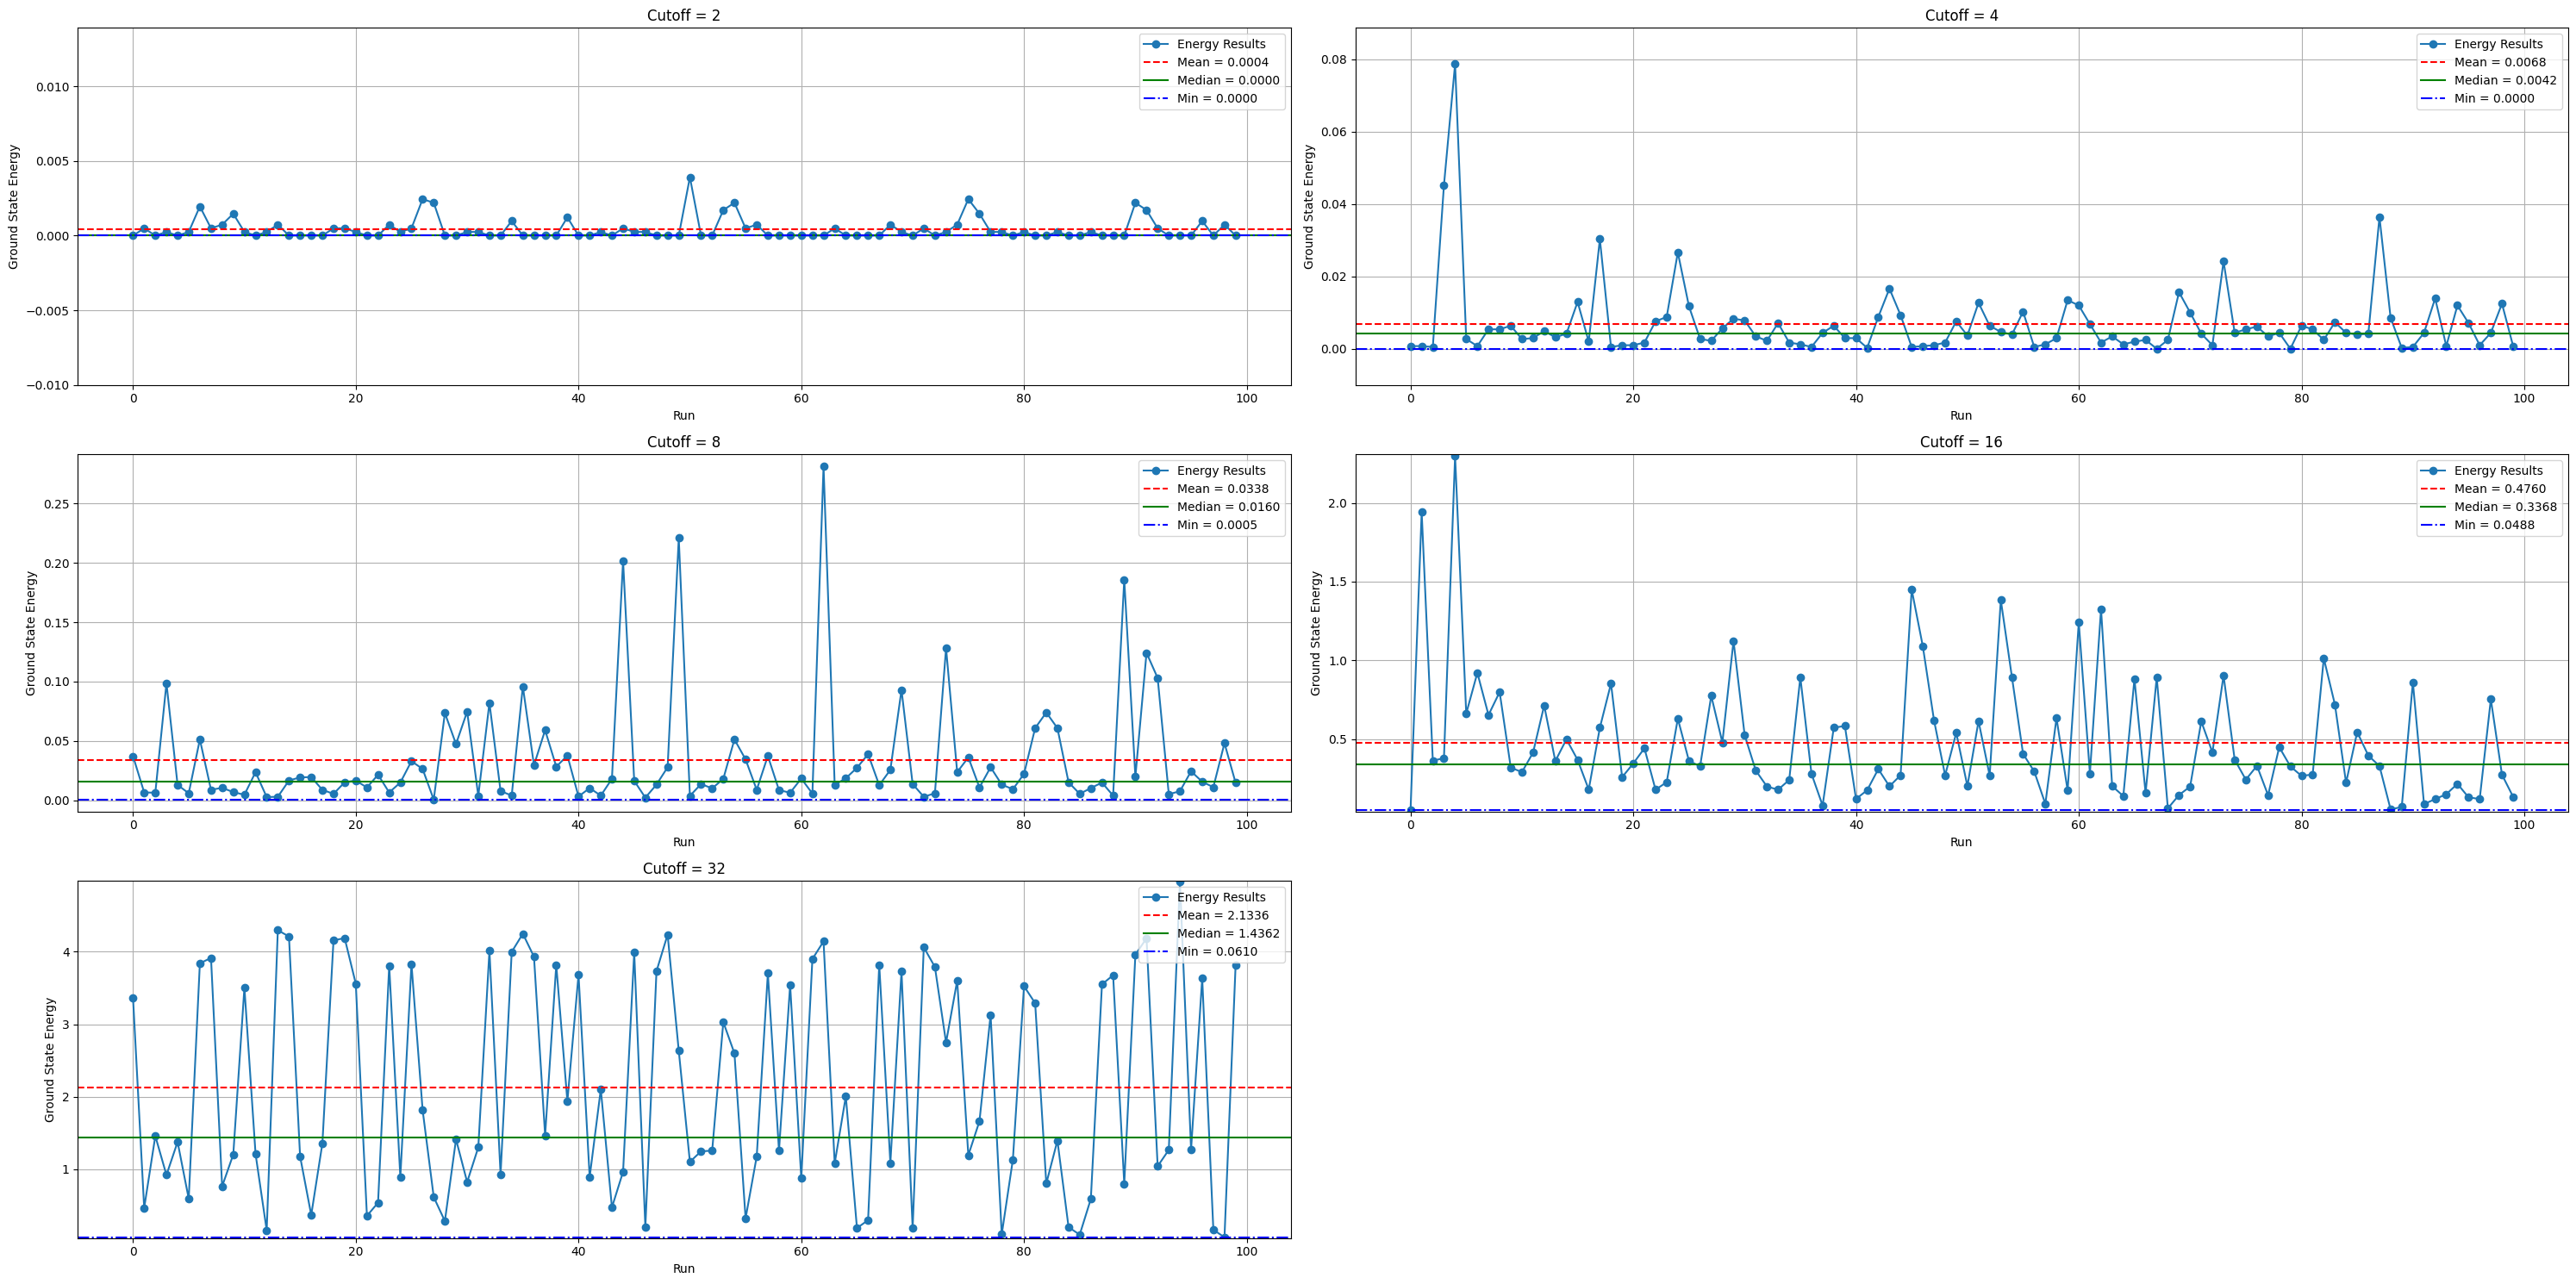

In [163]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 15))
axes = axes.flatten()

for idx, (cutoff, cutoff_data) in enumerate(data_dict.items()):
    
    results = cutoff_data['results']
    x_values = range(len(results))

    # Calculating statistics
    mean_value = np.mean(results)
    median_value = np.median(results)
    min_value = np.min(results)

    # Creating the plot
    ax = axes[idx]
    ax.plot(x_values, results, marker='o', label='Energy Results')

    # Plot mean, median, and min lines
    ax.axhline(y=mean_value, color='r', linestyle='--', label=f'Mean = {mean_value:.4f}')
    ax.axhline(y=median_value, color='g', linestyle='-', label=f'Median = {median_value:.4f}')
    ax.axhline(y=min_value, color='b', linestyle='-.', label=f'Min = {min_value:.4f}')

    ax.set_ylim(min_value - 0.01, max(results) + 0.01)
    ax.set_xlabel('Run')
    ax.set_ylabel('Ground State Energy')
    ax.set_title(f"Cutoff = {cutoff_data['cutoff']}")
    ax.legend()
    ax.grid(True)

fig.delaxes(axes[5])
plt.tight_layout()
plt.savefig(r"C:\Users\Johnk\OneDrive\Desktop\PhD 2024\Quantum Computing Code\Quantum-Computing\Qiskit\SUSY VQE\Minimizer\Files\QHO\results.png")
plt.show()
